## 3.4
変数選択

In [1]:
import scipy
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('./data/prostate/prostate.data', delimiter='\t',
                   index_col=0)
data_y = data.pop('lpsa')
mask_train = data.pop('train')

data_x_train = data[mask_train == 'T']
data_y_train = data_y[mask_train == 'T']
beta_intercept = data_y_train.mean()
# Centering for the training data
data_y_train_centered = data_y_train.subtract(beta_intercept)
data_x_train_normalized = data_x_train.apply(scipy.stats.zscore)
vec_y = data_y_train_centered.as_matrix()

data_x_test = data[mask_train == 'F']
data_x_test_normalized = data_x_test.apply(scipy.stats.zscore)
data_y_test = data_y[mask_train == 'F']
vec_y_test = data_y_test.as_matrix()

size_train = sum(mask_train == 'T')
size_test = sum(mask_train == 'F')
size_predictor = data_x_train.columns.size

In [3]:
def lambdas_from_edf(singular_squared:scipy.ndarray, interval:int) ->scipy.ndarray:
    """Given squared singular values of data matrix, calculate the lambdas
    with `interval` parameter to split unit intervals s.t. the resulting
    effective degrees of freedom are equidistant with 1/interval, via the
    Newton-Raphson method. e.g., if interval = 10, it produces lambdas for
    0, 0.5, 0.6, 0.7, ..."""
    p = singular_squared.size
    edfs = scipy.linspace(.5, p-.5, (p-1)*interval+1)
    threshold = 1e-3
    lambdas = []
    for edf in edfs:
        # Newton-Raphson
        lambda0 = (p-edf)/edf
        lambda1 = 1e6
        diff = lambda1 - lambda0
        while diff > threshold:
            num = (singular_squared/(singular_squared+lambda0)).sum()-edf
            denom = (singular_squared/((singular_squared+lambda0)**2)).sum()
            lambda1 = lambda0 + num/denom
            diff = lambda1 - lambda0
            lambda0 = lambda1
        lambdas.append(lambda1)
    lambdas.append(0)
    edfs = scipy.concatenate(([0], edfs, [p]))
    return edfs, scipy.array(lambdas)

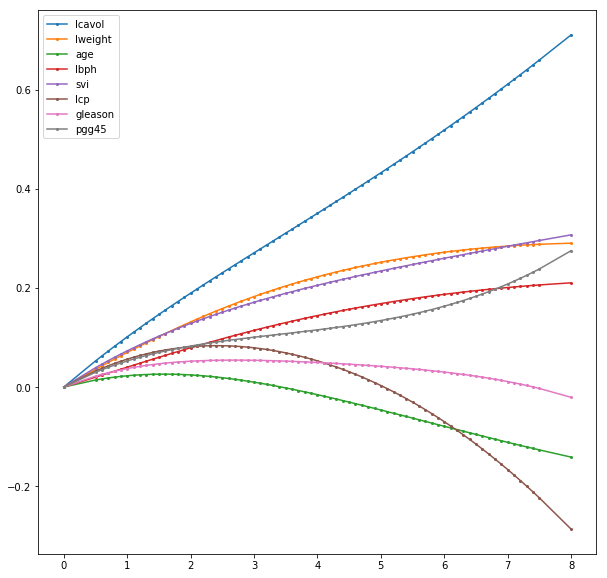

In [4]:
u, s, vh = scipy.linalg.svd(data_x_train_normalized, full_matrices=False)
s2 = s**2
edfs, lambdas = lambdas_from_edf(s2, 10)
# beta_ols = vh.T @ scipy.diag(scipy.reciprocal(s)) @ u.T @ vec_y
# print(beta_ols)
beta_ridge_array = [scipy.zeros(size_predictor)]
for lamb in lambdas:
    mat_diag = scipy.diag(s/(s2+lamb))
    beta_ridge = vh.T @ mat_diag @ u.T @ vec_y
    beta_ridge_array.append(beta_ridge)
beta_ridge_array = scipy.array(beta_ridge_array)

fig38 = plt.figure(figsize=(10, 10))
ax = fig38.add_subplot(1, 1, 1)
ax.plot(edfs, beta_ridge_array, 'o-', markersize=2)
ax.legend(data_x_train.columns)
plt.show()

## 3.17
スパムデータについて、解析

In [5]:
import numpy as np
import seaborn as sns
sns.set(style='white', context='notebook', palette='Set2')

## データの確認
>4601通のメール全てについて、email(0), spam(1)のどちらかのラベル
メール本文中に最も頻出する57種類の単語と句読点記号の相対出現頻度も与えられている

In [7]:
dataset = pd.read_csv("./data/spam/spambase.data", sep=",", header=None)

In [8]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


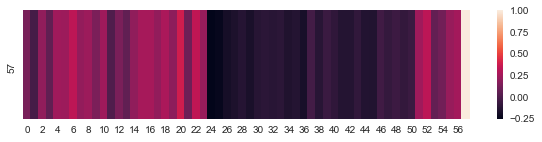

In [9]:
plt.figure(figsize=(10,2))
g= sns.heatmap(dataset.corr().tail(1))

### 次元削減：PCA

In [10]:
# from sklearn.decomposition import PCA

In [11]:
# pca = PCA(n_components=10)
# pca.fit(X)
# X = pd.DataFrame(pca.transform(X))

## モデル

In [12]:
from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import RidgeCV, LassoCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC

random_state = 2

In [13]:
X = dataset.loc[:, 0:56]
y = dataset[57]

In [14]:
# kfold
kfold = StratifiedKFold(n_splits=10)

In [15]:
def plot_learning_curve(est, X, y):
    training_set_size, train_scores, test_scores = learning_curve(est, X, y, train_sizes=np.linspace(0.1, 1, 30), cv=kfold, shuffle=True)
    estimator_name = est.__class__.__name__
    line = plt.plot(training_set_size, train_scores.mean(axis=1), 'o-', label="training scores " + estimator_name, color="r")
    plt.grid()
    plt.plot(training_set_size, test_scores.mean(axis=1), 'o-', label="test scores " + estimator_name, color="g")
    plt.xlabel('Training set size')
    plt.legend(loc='best')

### 分類

/Users/tela/.anyenv/envs/pyenv/versions/3.6.4/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/tela/.anyenv/envs/pyenv/versions/3.6.4/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/tela/.anyenv/envs/pyenv/versions/3.6.4/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/tela/.anyenv/envs/pyenv/versions/3.6.4/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


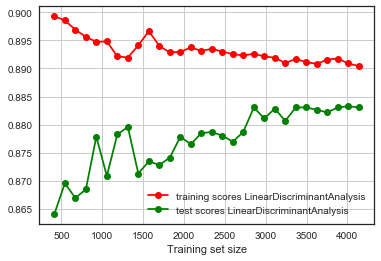

In [16]:
#linear discriminant analysis
plot_learning_curve(LinearDiscriminantAnalysis(), X, y)

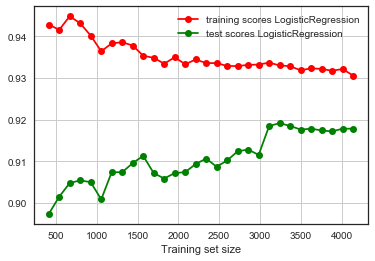

In [ ]:
#logistic regression
plot_learning_curve(LogisticRegression(random_state = random_state), X, y)

In [ ]:
# liner svm
plot_learning_curve(SVC(kernel="linear", C=0.025), X, y)

In [ ]:
# kneighbors classifier
plot_learning_curve(KNeighborsClassifier(), X, y)